Sử dụng thiết bị: mps
Kích thước ảnh: 128x128
Batch Size: 16
Số Epochs: 6

--- 2. Chuẩn bị Dataset và DataLoader (Dữ liệu giả lập) ---
Đang tạo 500 cặp ảnh/mask giả lập...


100%|██████████| 500/500 [00:00<00:00, 2923.41it/s]


Tạo dữ liệu giả lập xong.
Đã tạo Dataset và DataLoader: 400 train, 100 validation.
Kiểm tra DataLoader thành công. Shape ảnh: torch.Size([16, 1, 128, 128]), Shape mask: torch.Size([16, 1, 128, 128])

--- 3. Định nghĩa Mô hình U-Net ---
Đã khởi tạo mô hình U-Net.

--- 4. Thiết lập Huấn luyện ---
Sử dụng Loss: BCEWithLogitsLoss, Optimizer: Adam, LR=0.0001

--- Bắt đầu Huấn luyện ---


Epoch [1/6] - Train Loss: 0.4469, Val Loss: 0.4503
   => Lưu model tốt nhất: best_segmentation_unet.pth (Val Loss: 0.4503)


Epoch [2/6] - Train Loss: 0.3069, Val Loss: 0.2167
   => Lưu model tốt nhất: best_segmentation_unet.pth (Val Loss: 0.2167)


Epoch [3/6] - Train Loss: 0.2567, Val Loss: 0.2130
   => Lưu model tốt nhất: best_segmentation_unet.pth (Val Loss: 0.2130)


Epoch [4/6] - Train Loss: 0.2365, Val Loss: 0.2170


Epoch [5/6] - Train Loss: 0.2203, Val Loss: 0.2070
   => Lưu model tốt nhất: best_segmentation_unet.pth (Val Loss: 0.2070)


Epoch [6/6] - Train Loss: 0.2062, Val Loss: 0.1937
   => Lưu model tốt nhất: best_segmentation_unet.pth (Val Loss: 0.1937)
--- Huấn luyện hoàn tất ---


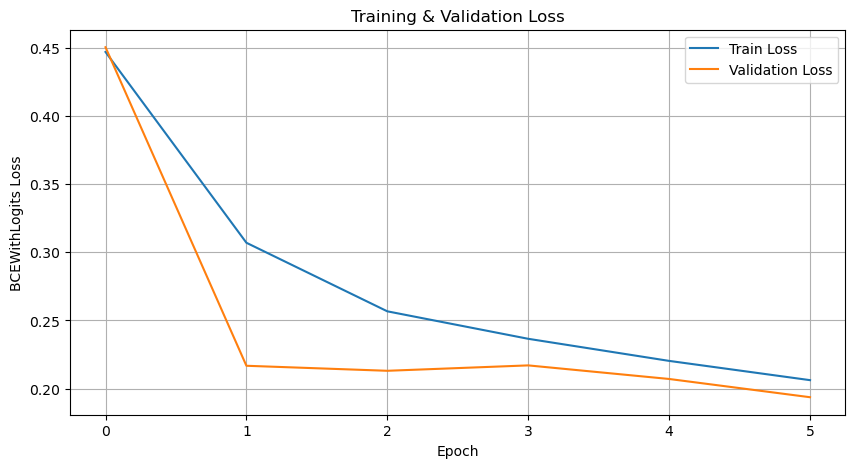


--- 5. Trực quan hóa kết quả trên tập Validation ---
Đã tải model tốt nhất từ 'best_segmentation_unet.pth'


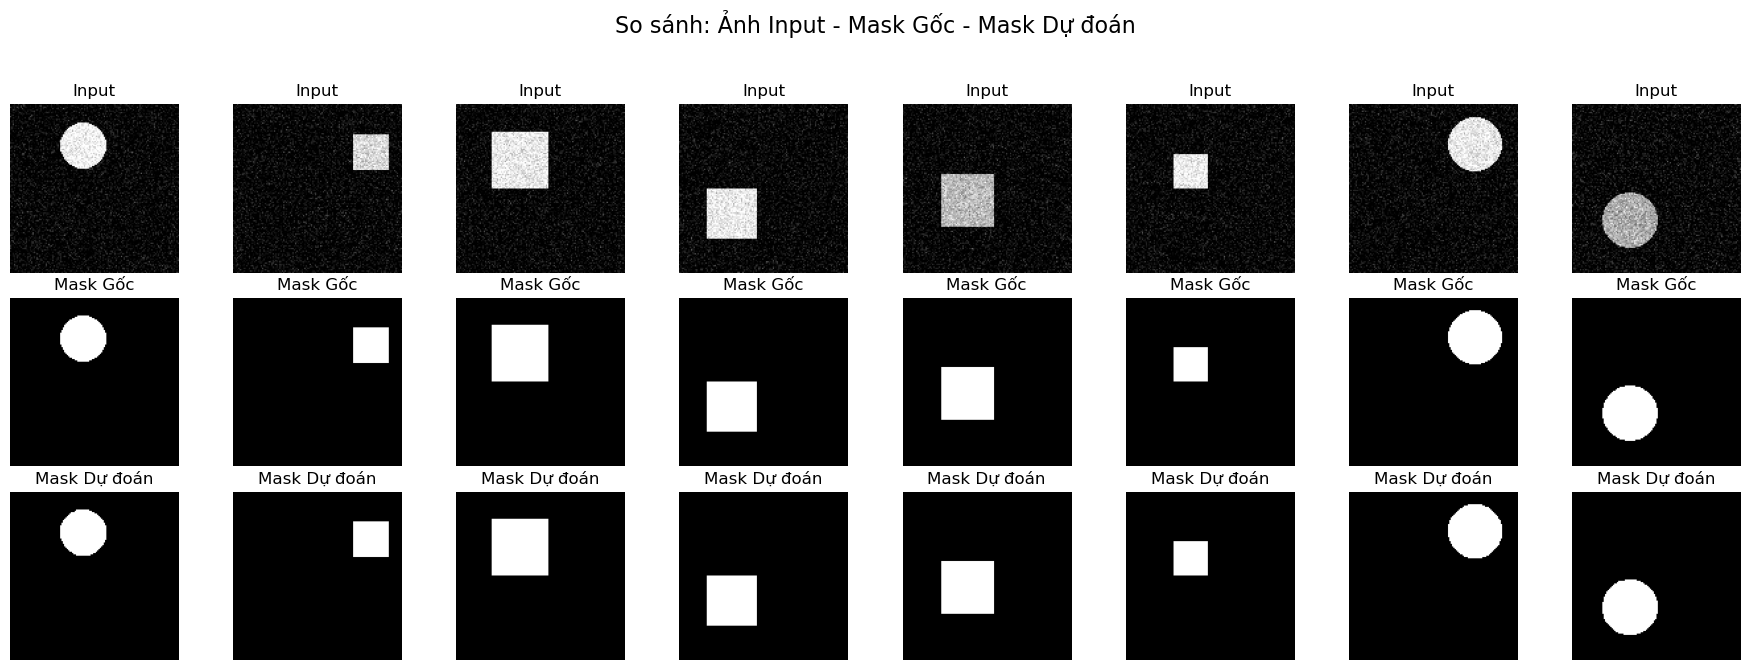


Chương trình Bài 5 hoàn tất.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
from PIL import Image, ImageDraw
import os
import time
import copy



DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
BATCH_SIZE = 16
NUM_EPOCHS = 6
LEARNING_RATE = 1e-4 # U-Net thường dùng LR nhỏ hơn
IMAGE_SIZE = 128
NUM_CLASSES = 1 # Phân đoạn nhị phân (object vs background)

print(f"Sử dụng thiết bị: {DEVICE}")
print(f"Kích thước ảnh: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Số Epochs: {NUM_EPOCHS}")


print("\n--- 2. Chuẩn bị Dataset và DataLoader (Dữ liệu giả lập) ---")
NUM_IMAGES_SYNTH = 500 # Số lượng ảnh tạo ra

class SegmentationDataset(Dataset):
    def __init__(self, num_images, img_size, transform=None):
        self.num_images = num_images
        self.img_size = img_size
        self.transform = transform
        self.images = []
        self.masks = []
        self._generate_data()

    def _generate_data(self):
        print(f"Đang tạo {self.num_images} cặp ảnh/mask giả lập...")
        for _ in tqdm(range(self.num_images)):
            img = Image.new('L', (self.img_size, self.img_size), color=0) # Ảnh grayscale nền đen
            mask = Image.new('L', (self.img_size, self.img_size), color=0) # Mask nền đen

            draw_img = ImageDraw.Draw(img)
            draw_mask = ImageDraw.Draw(mask)

            shape_type = random.choice(['rectangle', 'ellipse'])
            max_size = self.img_size // 3
            size = random.randint(max_size // 2, max_size)
            x1 = random.randint(10, self.img_size - size - 10)
            y1 = random.randint(10, self.img_size - size - 10)
            x2 = x1 + size
            y2 = y1 + size
            shape_fill = random.randint(150, 255) # Màu xám cho hình ảnh

            if shape_type == 'rectangle':
                draw_img.rectangle([x1, y1, x2, y2], fill=shape_fill)
                draw_mask.rectangle([x1, y1, x2, y2], fill=255) # Màu trắng cho mask
            else: # ellipse
                draw_img.ellipse([x1, y1, x2, y2], fill=shape_fill)
                draw_mask.ellipse([x1, y1, x2, y2], fill=255)

            # Chuyển sang NumPy array để thêm nhiễu
            img_np = np.array(img, dtype=np.float32) / 255.0
            mask_np = np.array(mask, dtype=np.float32) / 255.0 # Mask giá trị 0 hoặc 1

            # Thêm nhiễu Gaussian vào ảnh input
            noise = np.random.normal(0, 0.1, img_np.shape).astype(np.float32)
            img_noisy_np = np.clip(img_np + noise, 0, 1)

            self.images.append(img_noisy_np)
            self.masks.append(mask_np)
        print("Tạo dữ liệu giả lập xong.")

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Chuyển NumPy array thành Tensor
        # Thêm chiều kênh (C=1)
        image_tensor = torch.from_numpy(image).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)

        # (Không cần transform phức tạp cho dữ liệu giả lập này)
        # if self.transform:
        #     # Cần đảm bảo transform hoạt động đúng với ảnh/mask
        #     pass

        return image_tensor, mask_tensor

# Chia dữ liệu giả lập
full_dataset = SegmentationDataset(num_images=NUM_IMAGES_SYNTH, img_size=IMAGE_SIZE)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size], generator=generator)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Đã tạo Dataset và DataLoader: {len(train_dataset)} train, {len(val_dataset)} validation.")

# Kiểm tra nhanh DataLoader
try:
    img_check, mask_check = next(iter(train_loader))
    print(f"Kiểm tra DataLoader thành công. Shape ảnh: {img_check.size()}, Shape mask: {mask_check.size()}")
except Exception as e:
    print(f"Lỗi kiểm tra DataLoader: {e}")


print("\n--- 3. Định nghĩa Mô hình U-Net ---")

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder Path
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder Path
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # Final Convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Go down the Encoder path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x) # Save for skip connection
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Go up the Decoder path
        skip_connections = skip_connections[::-1] # Reverse for easy access

        for idx in range(0, len(self.ups), 2): # Step by 2 (ConvTranspose + DoubleConv)
            x = self.ups[idx](x) # Upsample (ConvTranspose)
            skip_connection = skip_connections[idx//2]

            # Handle potential size mismatch (simple crop if needed)
            if x.shape != skip_connection.shape:
                 # Crop skip_connection tensor to match x's size
                 # This might happen with odd input sizes or certain padding choices
                 target_size = x.shape[2:] # Get H, W from x
                 skip_connection = transforms.functional.center_crop(skip_connection, target_size)

            concat_skip = torch.cat((skip_connection, x), dim=1) # Concatenate along channel dim
            x = self.ups[idx+1](concat_skip) # Apply DoubleConv

        # Final output layer
        return self.final_conv(x)

model = UNet(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
print("Đã khởi tạo mô hình U-Net.")
# print(model) # Bỏ comment để xem cấu trúc


print("\n--- 4. Thiết lập Huấn luyện ---")
criterion = nn.BCEWithLogitsLoss() # Phù hợp cho binary segmentation output là logits
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"Sử dụng Loss: BCEWithLogitsLoss, Optimizer: Adam, LR={LEARNING_RATE}")

print("\n--- Bắt đầu Huấn luyện ---")
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
model_save_path = 'best_segmentation_unet.pth'

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]', leave=False)
    for images, masks in train_iterator:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE) # Target mask

        optimizer.zero_grad()
        logits = model(images) # Model outputs logits
        loss = criterion(logits, masks) # Compare logits with target mask [0, 1]
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iterator.set_postfix(loss=f"{loss.item():.4f}")
    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    val_iterator = tqdm(val_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Val]', leave=False)
    with torch.no_grad():
        for images, masks in val_iterator:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            logits = model(images)
            loss = criterion(logits, masks)
            val_loss += loss.item()
            val_iterator.set_postfix(loss=f"{loss.item():.4f}")
    avg_val_loss = val_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"   => Lưu model tốt nhất: {model_save_path} (Val Loss: {best_val_loss:.4f})")

print("--- Huấn luyện hoàn tất ---")

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss'); plt.xlabel('Epoch'); plt.ylabel('BCEWithLogits Loss'); plt.legend(); plt.grid(True); plt.show()


print("\n--- 5. Trực quan hóa kết quả trên tập Validation ---")
best_model = UNet(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
try:
    if os.path.exists(model_save_path):
        best_model.load_state_dict(torch.load(model_save_path, map_location=DEVICE))
        print(f"Đã tải model tốt nhất từ '{model_save_path}'")
    else:
        print(f"Không tìm thấy '{model_save_path}'. Sử dụng model cuối cùng.")
        best_model = model
except Exception as e:
    print(f"Lỗi tải model: {e}. Sử dụng model cuối cùng.")
    best_model = model
best_model.eval()

# Lấy một vài mẫu từ val_loader
vis_images, vis_masks = next(iter(val_loader))
vis_images = vis_images.to(DEVICE)

with torch.no_grad():
    pred_logits = best_model(vis_images)
    pred_probs = torch.sigmoid(pred_logits) # Chuyển logits thành xác suất [0, 1]
    pred_masks = (pred_probs > 0.5).float() # Threshold để tạo mask nhị phân 0/1

# Chuyển về CPU/NumPy để hiển thị
vis_images_np = vis_images.cpu().numpy()
vis_masks_np = vis_masks.cpu().numpy()
pred_masks_np = pred_masks.cpu().numpy()

n_display = 8
plt.figure(figsize=(18, 7))
plt.suptitle("So sánh: Ảnh Input - Mask Gốc - Mask Dự đoán", fontsize=16)
for i in range(min(n_display, len(vis_images_np))):
    ax = plt.subplot(3, n_display, i + 1)
    plt.imshow(np.squeeze(vis_images_np[i]), cmap='gray'); ax.set_title("Input"); ax.axis('off')

    ax = plt.subplot(3, n_display, i + 1 + n_display)
    plt.imshow(np.squeeze(vis_masks_np[i]), cmap='gray'); ax.set_title("Mask Gốc"); ax.axis('off')

    ax = plt.subplot(3, n_display, i + 1 + 2 * n_display)
    plt.imshow(np.squeeze(pred_masks_np[i]), cmap='gray'); ax.set_title("Mask Dự đoán"); ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


print("\nChương trình Bài 5 hoàn tất.")